<a href="https://colab.research.google.com/github/jhChoi1997/EE488_AI_Convergence_Capstone_Design_Anomaly_Detection_2022spring/blob/main/Experiment2/small_MNIST_Datat_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EE 488 AI Convergence Capstone Design : Anomaly Detection**
## **practice 2-1: Importance of Front end system and Data Augmentation**
###**Few train data case**###

When dataset is small, use data augmentation.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
import matplotlib.pyplot as plt
import torchsummary
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [3]:
plt.rc('font', size=20)

In [4]:
EPOCHS = 100
BATCH = 32
ANOMALY_NUM = 9

In [5]:
mnist_train = datasets.MNIST(root='MNIST_data/', train=True, transform=ToTensor(), download=True)
mnist_test = datasets.MNIST(root='MNIST_data/', train=False, transform=ToTensor(), download=True)

train_x = torch.tensor([mnist_train[i][0].numpy() for i, v in enumerate(mnist_train) if v[1] != ANOMALY_NUM])[0:1000]
train_num = torch.tensor([mnist_train[i][1] for i, v in enumerate(mnist_train) if v[1] != ANOMALY_NUM])[0:1000]
train_num_oh = F.one_hot(train_num)[0:1000]

unseen_x = torch.tensor([v[0].numpy() for v in mnist_test])
unseen_num = torch.tensor([v[1] for v in mnist_test])
unseen_y = torch.tensor([0 if v[1] != ANOMALY_NUM else 1 for v in mnist_test])


val_x = unseen_x[:int(len(unseen_x) / 2)]
val_num = unseen_num[:int(len(unseen_x) / 2)]
val_num_oh = F.one_hot(val_num)
val_num_oh = torch.cat((val_num_oh[:,0:ANOMALY_NUM],val_num_oh[:,ANOMALY_NUM+1:]), dim=1)
val_y = unseen_y[:int(len(unseen_y) / 2)]

test_x = unseen_x[int(len(unseen_x) / 2):]
test_num = unseen_num[int(len(unseen_x) / 2):]
test_num_oh = F.one_hot(test_num)
test_num_oh = torch.cat((test_num_oh[:,0:ANOMALY_NUM],test_num_oh[:,ANOMALY_NUM+1:]), dim=1)
test_y = unseen_y[int(len(unseen_y) / 2):]

train_dataset = TensorDataset(train_x, train_num_oh)
val_dataset = TensorDataset(val_x, val_num_oh, val_y)
test_dataset = TensorDataset(test_x, test_num_oh, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  after removing the cwd from sys.path.


In [6]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

1000
5000
5000


Data Augmentation

In [7]:
def shift_MNIST(images,num, replicate):
    B, _, X, Y = images.shape
    original_images = images
    new_images = torch.zeros((B*replicate,1,X,Y))
    new_num = torch.tile(num, dims=(replicate,1))
    for idx in range(B*replicate):
        i_image = images[idx%B,0,:,:]
        mv_x = np.random.randint(low=-4,high =4)
        mv_y = np.random.randint(low=-4,high =4)
        i_image_new = torch.zeros(i_image.shape)
        if mv_x>=0 and mv_y>=0:
            i_image_new[mv_x:,mv_y:] = i_image[:28-mv_x,:28-mv_y]
        elif mv_x>=0 and mv_y<0:
            i_image_new[mv_x:,:28+mv_y] = i_image[:28-mv_x,-mv_y:]
        elif mv_x<0 and mv_y>=0:
            i_image_new[:28+mv_x,mv_y:] = i_image[-mv_x:,:28-mv_y]
        else:
            i_image_new[:28+mv_x,:28+mv_y] = i_image[-mv_x:,-mv_y:]
        new_images[idx,0,:,:] = i_image_new
    return new_images, new_num, original_images

In [8]:
train_x, train_num_oh, original_train_x = shift_MNIST(train_x,train_num_oh,50)
train_dataset = TensorDataset(train_x, train_num_oh)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH)

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

50000
5000
5000


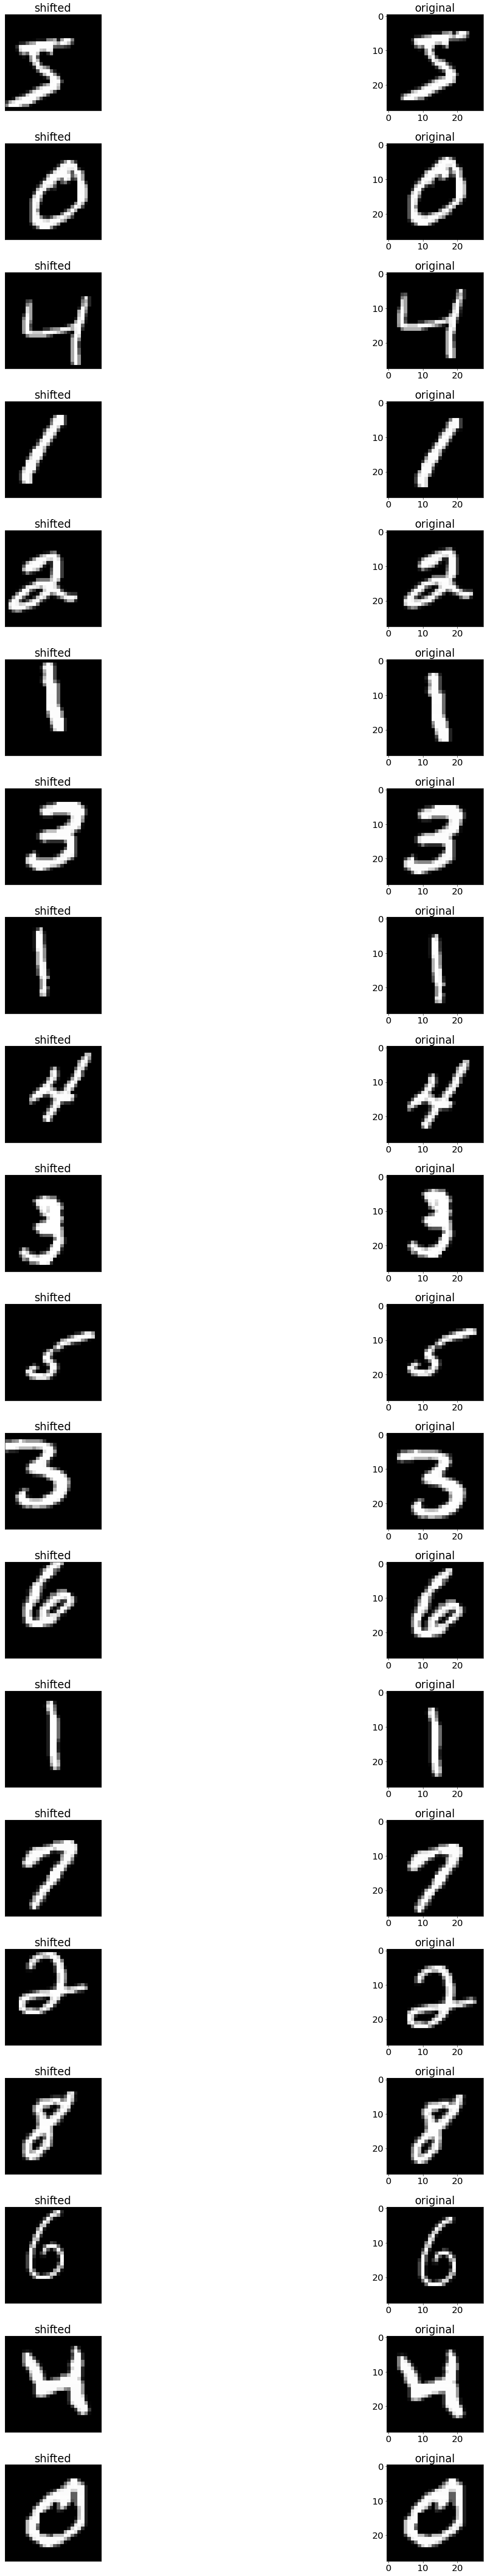

In [9]:
n = 20
plt.figure(figsize=(40, 80))

for i in range(n):
    input_image = train_dataset[i][0].to(device)
    original_input_image = original_train_x[i][0].to(device)
    input_number = train_dataset[i][1]
    ax = plt.subplot(n, 2, 2*i+1)
    plt.imshow(input_image[0].cpu())
    plt.title('shifted')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    ax2 = plt.subplot(n, 2, 2*i+2)
    plt.imshow(original_input_image.cpu())
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.tight_layout()


plt.show()

Complete the below code.

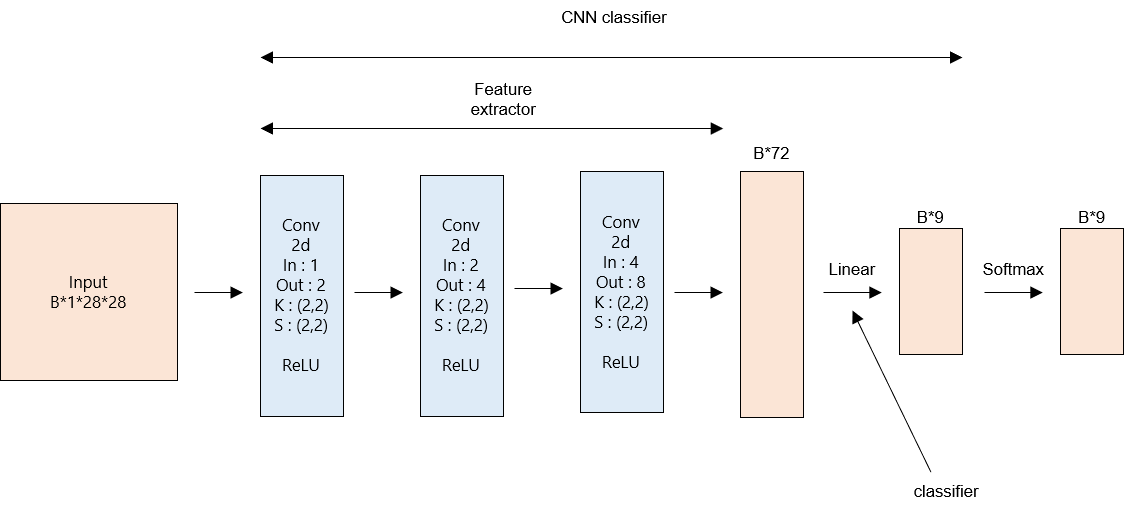

In [10]:
class ClassificationCNNModel(nn.Module):
    def __init__(self):
        super(ClassificationCNNModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1,2,kernel_size = (2,2), stride = (2,2)),
            nn.ReLU(),
            nn.Conv2d(2,4,kernel_size = (2,2), stride = (2,2)),
            nn.ReLU(),
            nn.Conv2d(4,8,kernel_size = (2,2), stride = (2,2)),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(72,9)
        )

    def forward(self, x):
        out = self.feature_extractor(x)
        out = out.reshape(out.shape[0],-1)
        out = self.classifier(out)
        return out

In [11]:
model = ClassificationCNNModel().to(device)
print(model)

ClassificationCNNModel(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 2, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(2, 4, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(4, 8, kernel_size=(2, 2), stride=(2, 2))
    (5): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=72, out_features=9, bias=True)
  )
)


In [12]:
loss_fn = nn.CrossEntropyLoss()
def anomaly_score(logits):
    prob = torch.softmax(logits, dim=1)
    MSP = torch.max(prob, dim=1).values
    return torch.tensor(1) - MSP
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [13]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    for batch, y in enumerate(dataloader):
        pred = model(y[0].to(device))


        loss = loss_fn(pred, y[1].to(device).float())
        

        for idata in range(pred.shape[0]):

            iloss = loss_fn(pred[idata:idata+1,:], y[1][idata:idata+1,:].to(device).float())
            losses.append(iloss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 300 == 0:
            loss, current = loss.item(), batch * pred.shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


    return np.mean(losses)

In [14]:
def test(dataloader, model, loss_fn, anomaly_score, draw_mode = False):
    model.eval()

    y_true, y_pred = [], []

    normal_loss = []
    normal_scores = []
    anomaly_scores  =[]

    with torch.no_grad():
      
        for batch, num, anomaly in dataloader:

            batch = batch.to(device)
            num = num.to(device)
            anomaly = anomaly.to(device)
            output = model(batch)

            for idata in range(output.shape[0]):

                iloss = loss_fn(output[idata:idata+1,:], num[idata:idata+1,:].to(device).float())
                iscore = anomaly_score(output[idata:idata+1,:])
                if anomaly[idata] == 0:
                    normal_loss.append(iloss)
                    normal_scores.append(iscore)
                elif anomaly[idata] == 1:
                    anomaly_scores.append(iscore)


            score = anomaly_score(output)

            y_true.extend(anomaly.tolist())
            y_pred.extend(score.tolist())

    roc_auc = metrics.roc_auc_score(y_true, y_pred)

    if draw_mode:
        fpr, tpr, _ = metrics.roc_curve(y_true,y_pred)
        plt.figure(figsize=(10,10))
        plt.plot(fpr,tpr)
        plt.title('ROC curve')
        plt.xlabel('FPR')
        plt.ylabel('TPR')


    print(f'AUC: {roc_auc:>0.3f}')
    normal_loss = [i.item() for i in normal_loss]
    normal_scores = [i.item() for i in normal_scores]
    anomaly_scores = [i.item() for i in anomaly_scores]

    normal_loss_mean = np.mean(normal_loss)
    normal_score_mean = np.mean(normal_scores)
    anomaly_score_mean = np.mean(anomaly_scores)

    print(f'normal loss : {normal_loss_mean}')

    return roc_auc.item(), normal_loss_mean, normal_score_mean, anomaly_score_mean, normal_scores, anomaly_scores

In [15]:
train_losses = []
val_normal_losses= []
val_normal_scores = []
val_anomaly_scores = []
roc_auc = []

best_auc = 0.0
best_model = model.to(device)

for t in range(EPOCHS):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    auc,val_normal_loss, val_normal_score, val_anomaly_score, _, _ = test(val_dataloader, model, loss_fn, anomaly_score)

    train_losses.append(train_loss)
    val_normal_losses.append(val_normal_loss)
    val_normal_scores.append(val_normal_score)
    val_anomaly_scores.append(val_anomaly_score)

    roc_auc.append(auc)

    if auc > best_auc:
        best_model, best_auc = model, auc

Epoch 1
-------------------------------
loss: 2.197793  [    0/50000]
loss: 2.151657  [ 9600/50000]
loss: 1.641382  [19200/50000]
loss: 1.250627  [28800/50000]
loss: 0.760019  [38400/50000]
loss: 1.224512  [48000/50000]
AUC: 0.790
normal loss : 0.8259525275769712
Epoch 2
-------------------------------
loss: 0.960368  [    0/50000]
loss: 0.935112  [ 9600/50000]
loss: 1.065492  [19200/50000]
loss: 0.877969  [28800/50000]
loss: 0.399747  [38400/50000]
loss: 1.034148  [48000/50000]
AUC: 0.742
normal loss : 0.6809191682849619
Epoch 3
-------------------------------
loss: 0.654017  [    0/50000]
loss: 0.698316  [ 9600/50000]
loss: 1.053337  [19200/50000]
loss: 0.717983  [28800/50000]
loss: 0.297205  [38400/50000]
loss: 0.970249  [48000/50000]
AUC: 0.728
normal loss : 0.6493702261994957
Epoch 4
-------------------------------
loss: 0.593284  [    0/50000]
loss: 0.601387  [ 9600/50000]
loss: 1.044330  [19200/50000]
loss: 0.653960  [28800/50000]
loss: 0.274556  [38400/50000]
loss: 0.942111  [4

<Figure size 432x288 with 0 Axes>

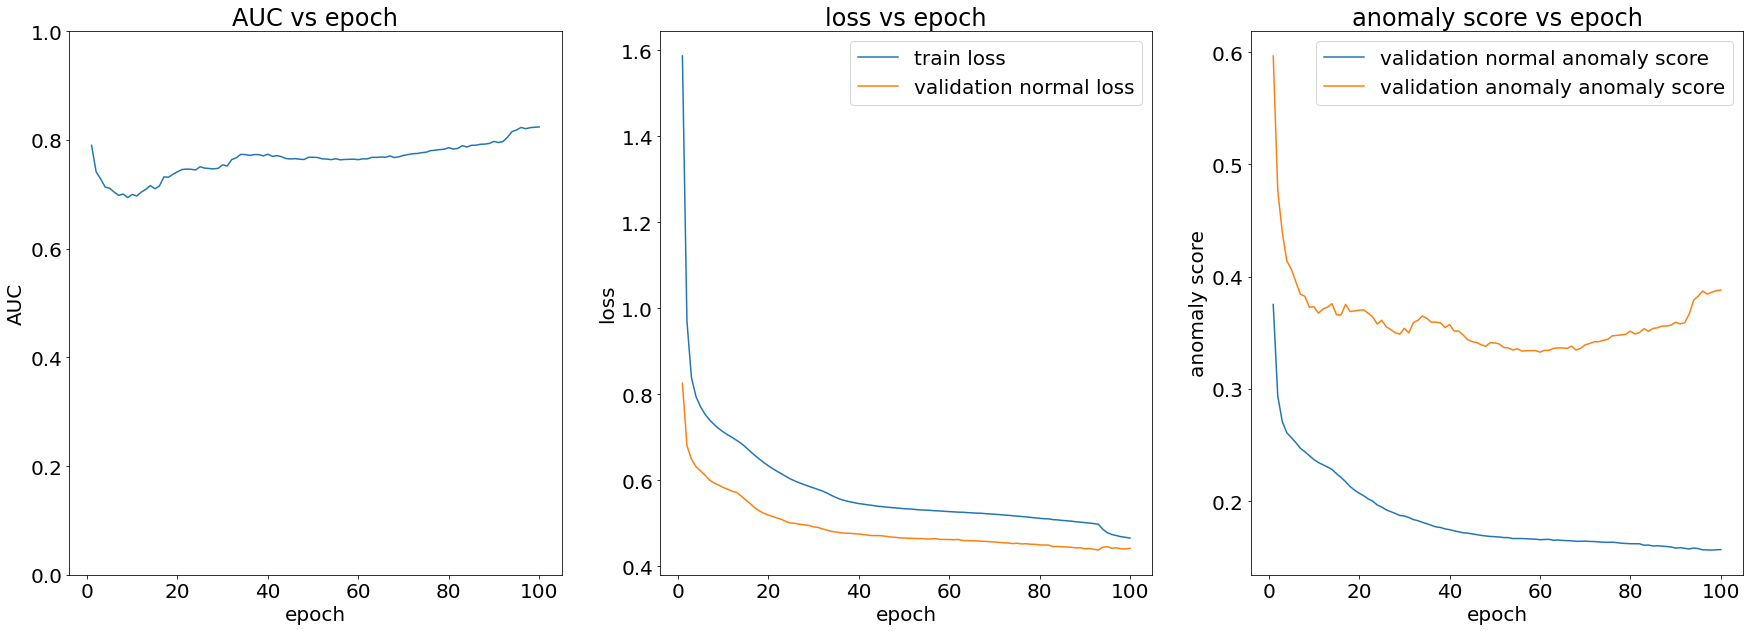

In [16]:
plt.clf()
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.plot(list(range(1,len(roc_auc)+1)),roc_auc)
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('AUC vs epoch')
plt.ylim([0, 1])

plt.subplot(1,3,2)
plt.plot(list(range(1,len(train_losses)+1)),train_losses)
plt.plot(list(range(1,len(val_normal_losses)+1)),val_normal_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs epoch')
plt.legend(['train loss', 'validation normal loss'])

plt.subplot(1,3,3)
plt.plot(list(range(1,len(val_normal_scores)+1)),val_normal_scores)
plt.plot(list(range(1,len(val_anomaly_scores)+1)),val_anomaly_scores)
plt.xlabel('epoch')
plt.ylabel('anomaly score')
plt.title('anomaly score vs epoch')
plt.legend(['validation normal anomaly score','validation anomaly anomaly score'])

AUC: 0.843
normal loss : 0.3106283719499254


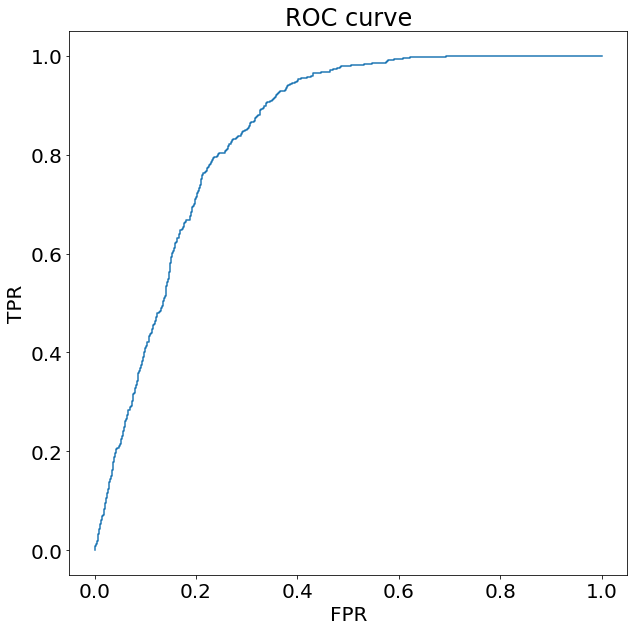

In [17]:
test_auc,test_normal_loss, test_normal_score, test_anomaly_score, test_normal_scores, test_anomaly_scores = test(test_dataloader, best_model, loss_fn, anomaly_score, draw_mode=True)

<Figure size 720x720 with 0 Axes>

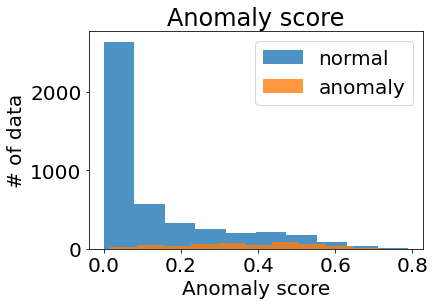

<Figure size 720x720 with 0 Axes>

In [18]:
plt.hist(test_normal_scores, alpha = 0.8)
plt.hist(test_anomaly_scores, alpha = 0.8)
plt.title('Anomaly score')
plt.xlabel('Anomaly score')
plt.ylabel('# of data')
plt.legend(['normal','anomaly'])
plt.figure(figsize=(10,10))

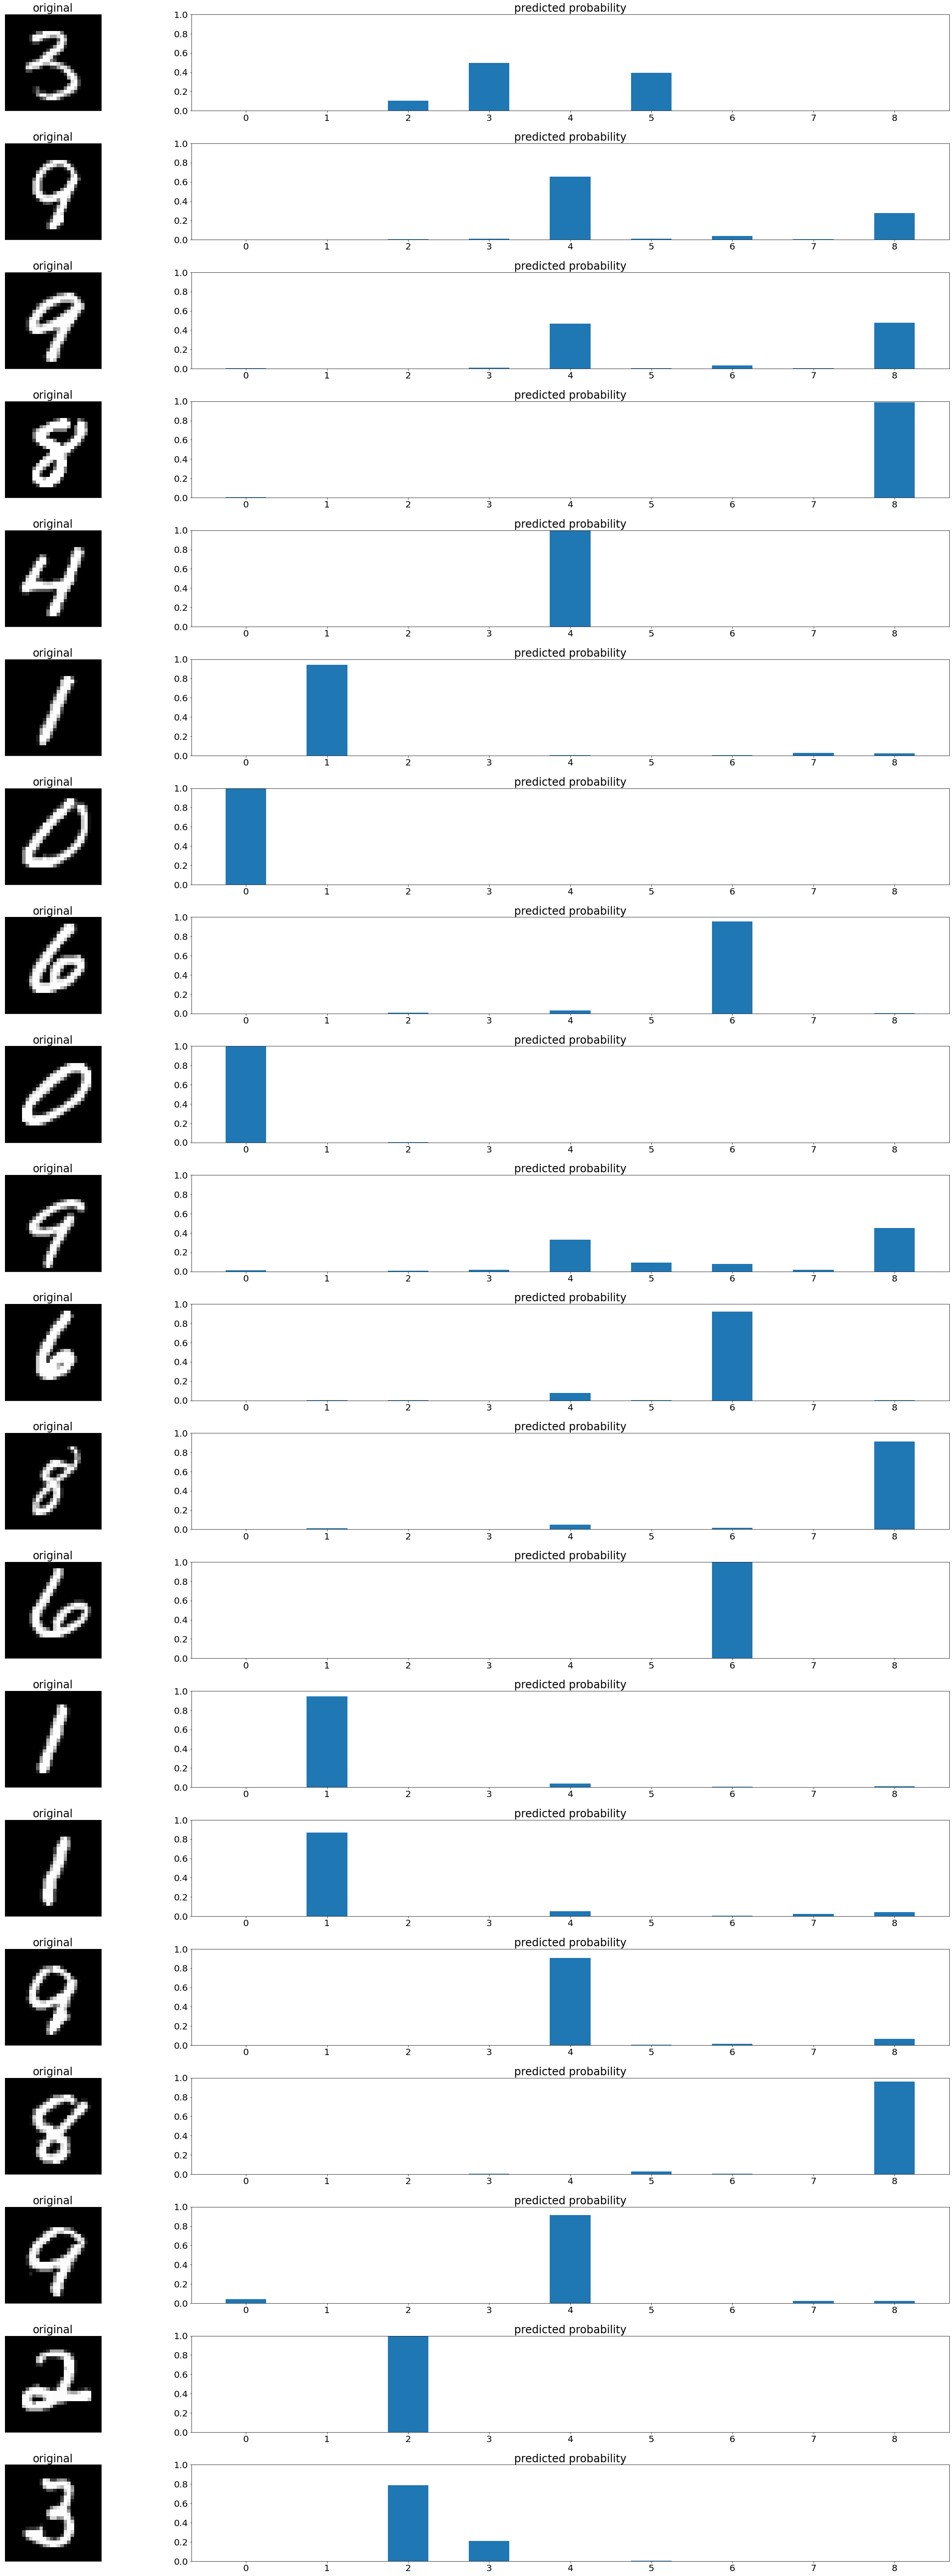

In [19]:
n = 20
plt.figure(figsize=(40, 80))

for i in range(n):
    input_image = test_dataset[i][0].to(device)
    pred_prob = torch.softmax(best_model(input_image.unsqueeze(0)),dim=1).cpu().detach().squeeze().numpy()

    ax = plt.subplot(n, 2, 2*i+1)
    plt.imshow(input_image[0].cpu())
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax2 = plt.subplot(n, 2, 2*i+2)
    ax2.set_ylim([0,1])
    classify_as = np.array(list(range(ANOMALY_NUM)) + list(range(ANOMALY_NUM+1,9)))
    plt.bar(classify_as, pred_prob, width = 0.5, tick_label = [str(i) for i in classify_as])
    #plt.imshow(output_image[0].squeeze().detach().cpu())
    plt.title('predicted probability')
    plt.tight_layout()

plt.show()